# FB Phophet Tutorial

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' #nicer rendering of plots in retina displays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
sns.set()

In [3]:
#Load r2py so we can pass objects between Python and R.
#Note: this won't work for Prophet objects (model)
%load_ext rpy2.ipython 

In [5]:
%%R
library(prophet)
library(dplyr)

## Use Cases

Not all forecasting problems can be solved by the same procedure. Prophet is optimized for the business forecast tasks we have encountered at Facebook, which typically have any of the following characteristics:

+ hourly, daily, or weekly observations with at least a few months (preferably a year) of history
+ strong multiple “human-scale” seasonalities: day of week and time of year
+ important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl)
+ a reasonable number of missing observations or large outliers
+ historical trend changes, for instance due to product launches or logging changes
+ trends that are non-linear growth curves, where a trend hits a natural limit or saturates

More information [here](https://research.fb.com/prophet-forecasting-at-scale/)

## How Prophet works

At its core, the Prophet procedure is an **additive regression model** with four main components:

+ A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
+ A yearly seasonal component modeled using Fourier series.
+ A weekly seasonal component using dummy variables.
+ A user-provided list of important holidays.

The Prophet model is fitted using Stan’s probabilistic programming language. **Stan** performs the MAP (maximum a posteriori) optimization for parameters extremely quickly (<1 second), gives the option to estimate parameter uncertainty using the Hamiltonian Monte Carlo algorithm, and allows to re-use the fitting procedure across multiple interface languages.

## Quick Start

The input to Prophet is **always a dataframe with two columns: ds and y.** The ds (datestamp) column **must contain 
a date or datetime (either is fine)**. The y column **must be numeric**, and represents the measurement we wish to forecast.

As an example, let’s look at a *time series of daily page views for the Wikipedia page for Peyton Manning*. We scraped this data using the Wikipediatrend package in R. Peyton Manning provides a nice example because it illustrates some of Prophet’s features, like **multiple seasonality, changing growth rates, and the ability to model special days** (such as Manning’s playoff and superbowl appearances).

In [6]:
#Import the data and log-transform the y variable.
df = pd.read_csv('Data/example_wp_peyton_manning.csv', parse_dates = ['ds'])
df['y'] = np.log(df['y'])
df.head() #length: 2904

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


We fit the model by instantiated a new Prophet object. Any settings to the forecasting procedure are passed into the constructor. Then you call its fit method and pass in the historical dataframe. Fitting should take 1-5 seconds.

In [7]:
model = Prophet()
model.fit(df);

Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe. By default it will also include the dates from the history, so we will see the model fit as well.

In [8]:
future = model.make_future_dataframe(periods=365)
future.tail() #2904 + 365 = 3269

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


The predict method will assign each row in future a predicted value which it names yhat. **If you pass in historical dates, it will provide an in-sample fit.** The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [9]:
forecast = model.predict(future) #this will take a couple of seconds
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.213787,7.549439,8.902335
3266,2017-01-16,8.538876,7.797002,9.266316
3267,2017-01-17,8.326293,7.604521,9.071512
3268,2017-01-18,8.158930,7.466425,8.913933
3269,2017-01-19,8.170898,7.463770,8.921628


You can plot the forecast by calling the Prophet.plot method and passing in your forecast dataframe.

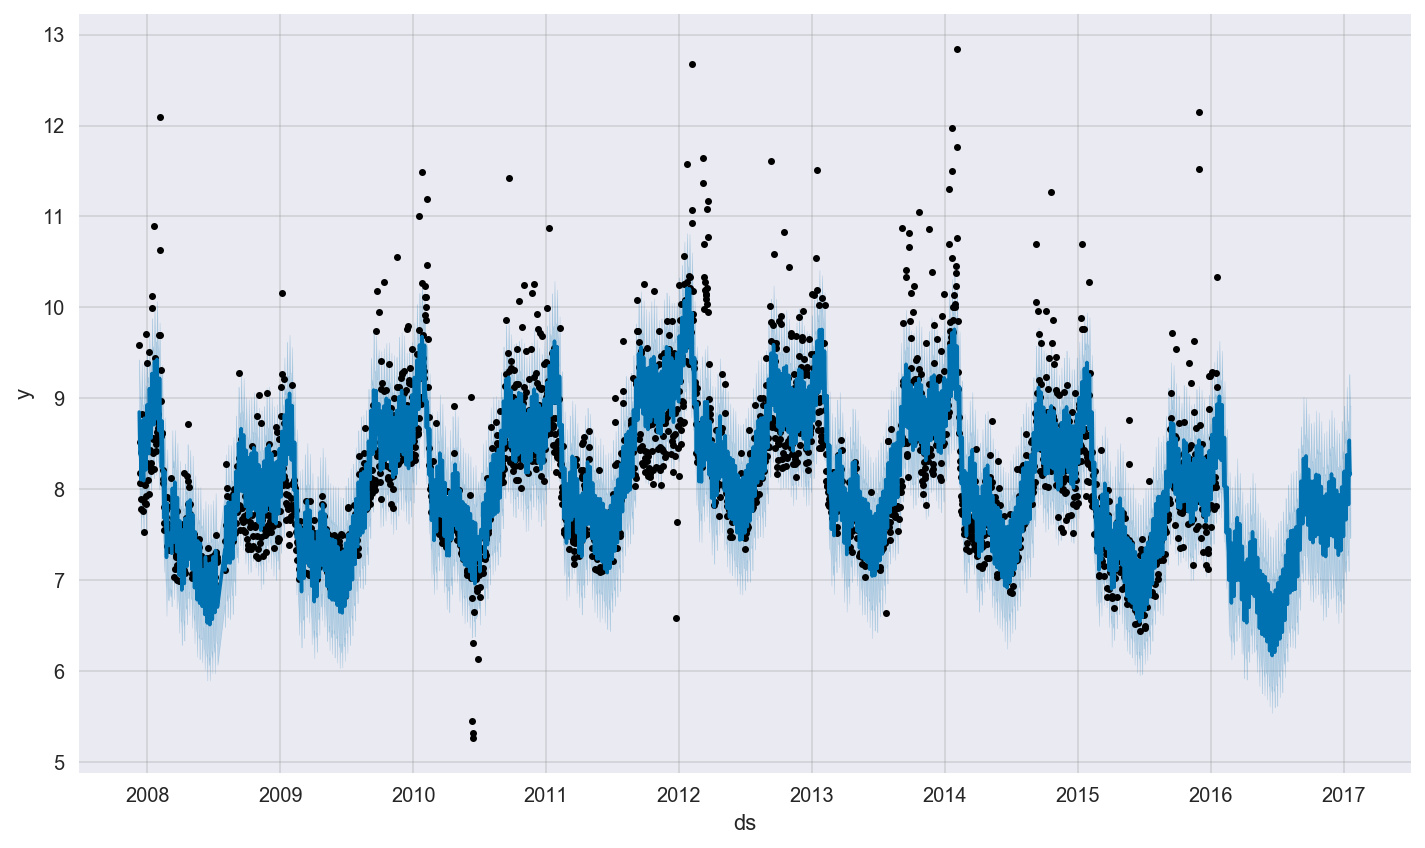

In [10]:
model.plot(forecast); #plot is called from matplotlib

Since Peyton Manning is an American football player, you can see that yearly seasonality plays and important role, while weekly periodicity is also clearly present. Finally you see certain events (like playoff games he appears in) may also be modeled.

If you want to see the forecast components, you can use the Prophet.plot_components method. By **default** you’ll see the **trend, yearly seasonality, and weekly seasonality of the time series**. If you include **holidays**, you’ll see those here, too.

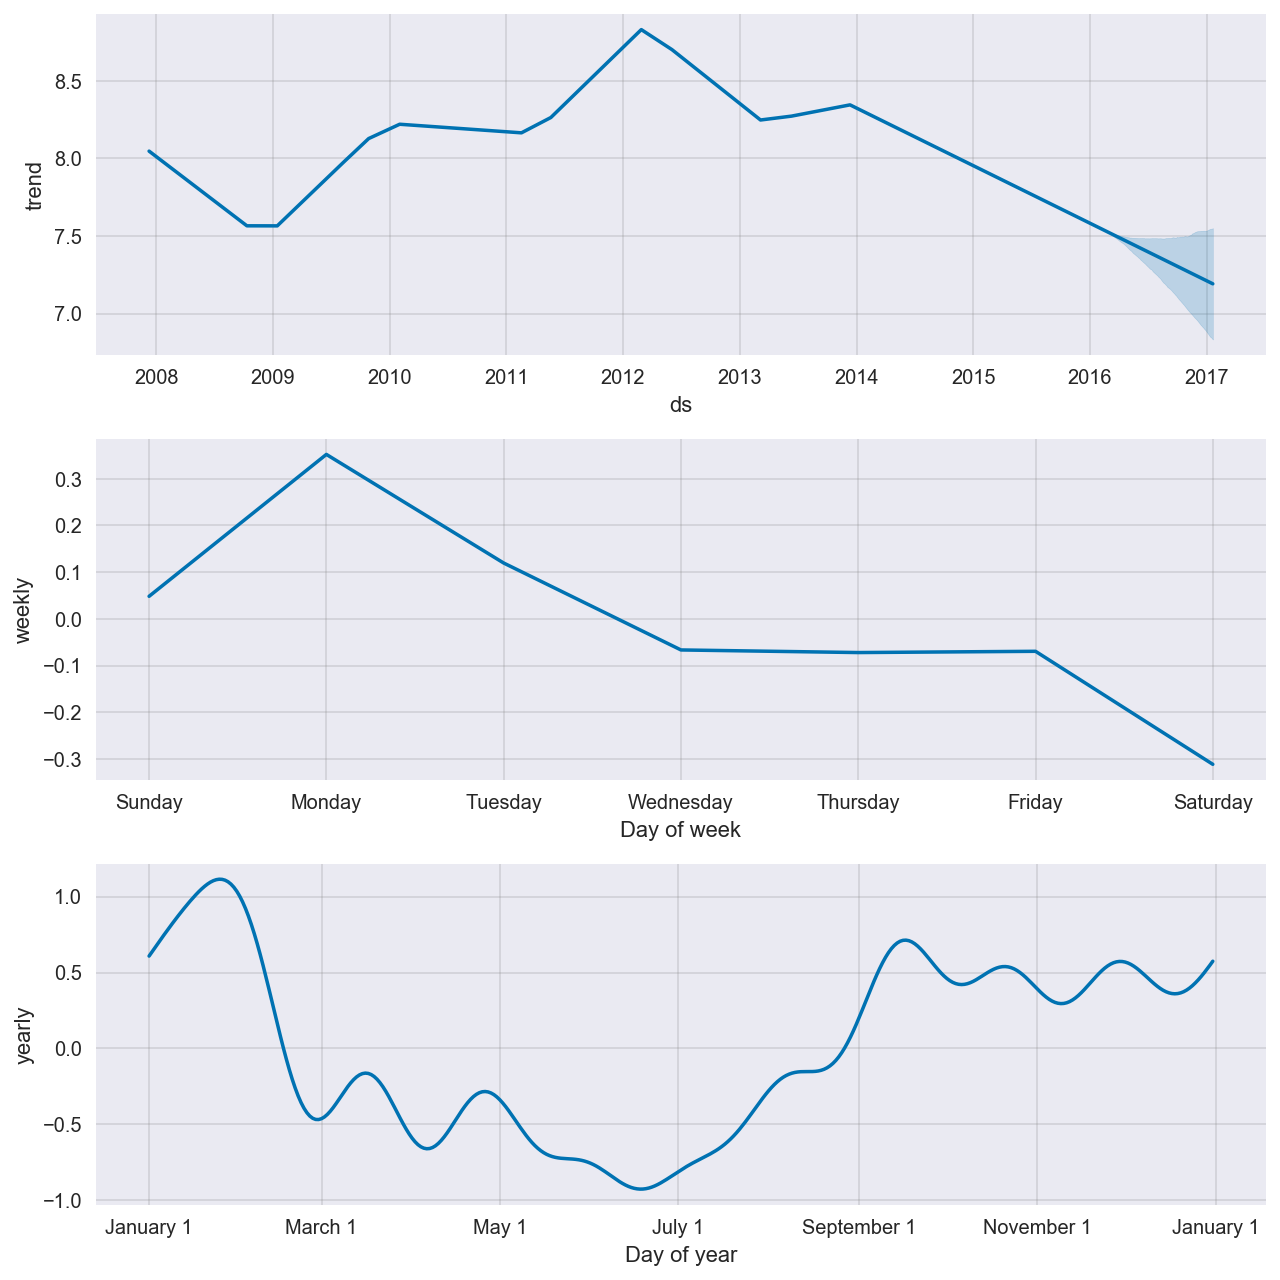

In [11]:
model.plot_components(forecast);

The plots more clearly show the yearly seasonality associated with browsing to Peyton Manning’s page (football season and the playoffs), as well as the weekly seasonality: more visits on the day of and after games (Sundays and Mondays). You can also notice the downward adjustment to the trend component since he has retired recently.

## Forecasting Growth

By **default**, Prophet uses a **linear model** for its forecast. When forecasting **growth**, there is usually some maximum achievable point: total market size, total population size, etc. This is called **the carrying capacity**, and the forecast should saturate at this point.

Prophet allows you to make forecasts using a **logistic growth trend model**, with a specified carrying capacity. We must specify the carrying capacity in a column cap. Here we will assume a particular value, but this would usually be set using data or expertise about the market size. The important things to note are that cap **must be specified for every row** in the dataframe, and that **it does not have to be constant**. If the market size is growing, then cap can be an increasing sequence.

In [12]:
df_grow = df.copy()
df_grow['cap'] = 13.0 #log number of page visits capacity

In [13]:
#We fit the model as before, except for an additional argument to specify logistic growth:
m0 = Prophet(growth='logistic')
m0.fit(df_grow);

We make a dataframe for future predictions as before, except we must also specify the capacity in the future. Here we keep capacity constant at the same value as in the history, and forecast 3 years into the future:

In [14]:
future_gr = m0.make_future_dataframe(periods=1826)
future_gr['cap'] = 13.0
forecast0 = m0.predict(future_gr)

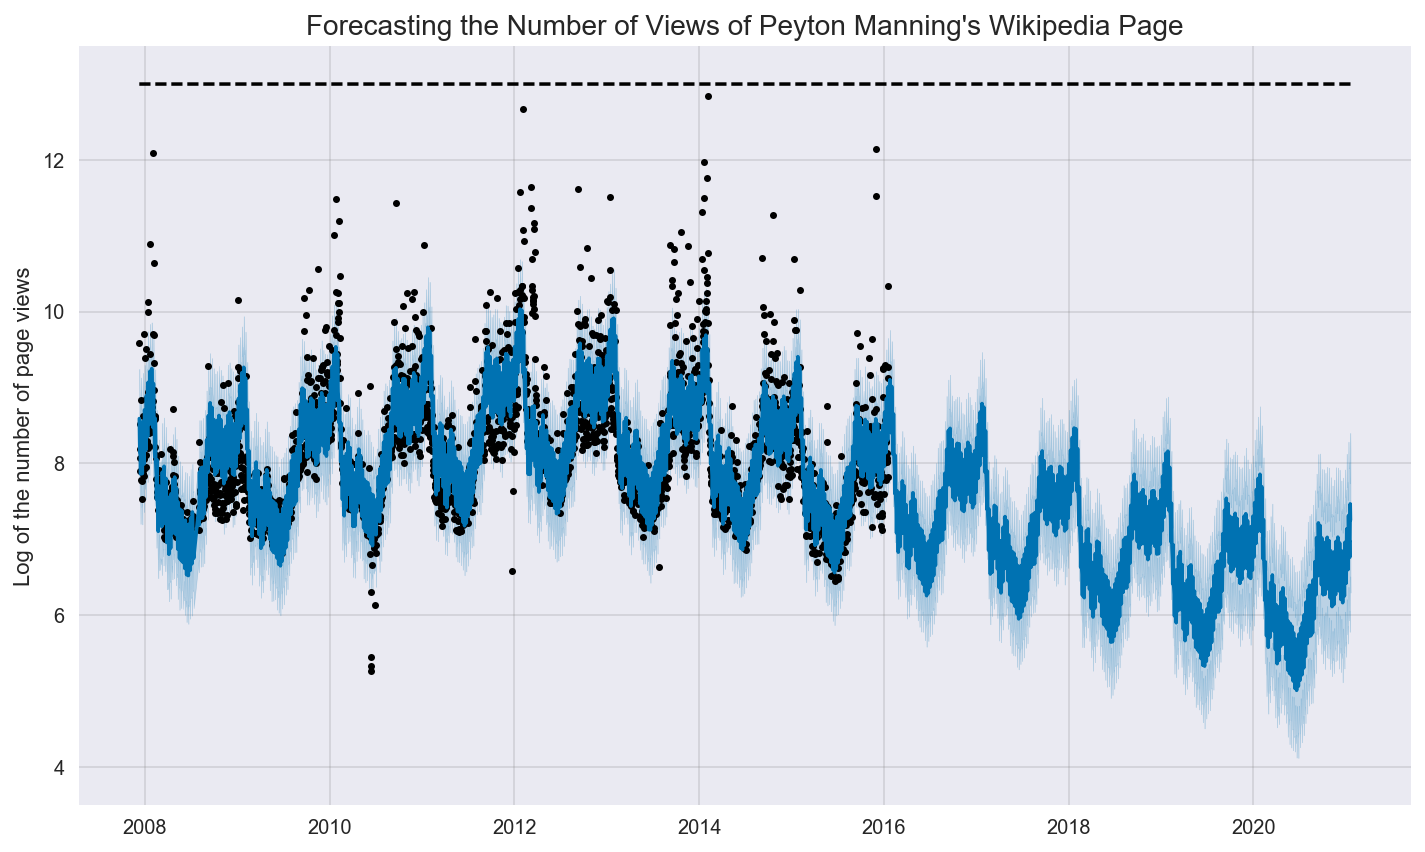

In [15]:
m0.plot(forecast0);
plt.ylim(3.5, 13.5);
plt.ylabel('Log of the number of page views')
plt.xlabel('')
plt.title("Forecasting the Number of Views of Peyton Manning's Wikipedia Page", size = 14);

## Trend Changepoints

Real time series frequently have **abrupt changes** in their trajectories. By default, Prophet will **automatically detect these changepoints** and will allow the trend to adapt appropriately. However, if you wish to have **finer control** over this process (e.g., Prophet missed a rate change, or is overfitting rate changes in the history), then there are several input arguments you can use.

Prophet detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change. It then puts a **sparse prior** on the magnitudes of the rate changes (equivalent to L1 regularization) - this essentially means that Prophet has a large number of possible places where the rate can change, but will use as few of them as possible.

In the Peyton Manning forecast, Prophet by default specifies 25 potential changepoints which are uniformly placed in the first 80% of the time series. 
Even though we have a lot of places where the rate can possibly change, because of the sparse prior, most of these changepoints go unused.
The number of potential changepoints can be set using the argument n_changepoints, but this is better tuned by **adjusting the regularization**.

If the trend changes are being **overfit** (too much flexibility) or **underfit** (not enough flexiblity), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to **0.05**. Increasing it will make the trend *more* flexibile:

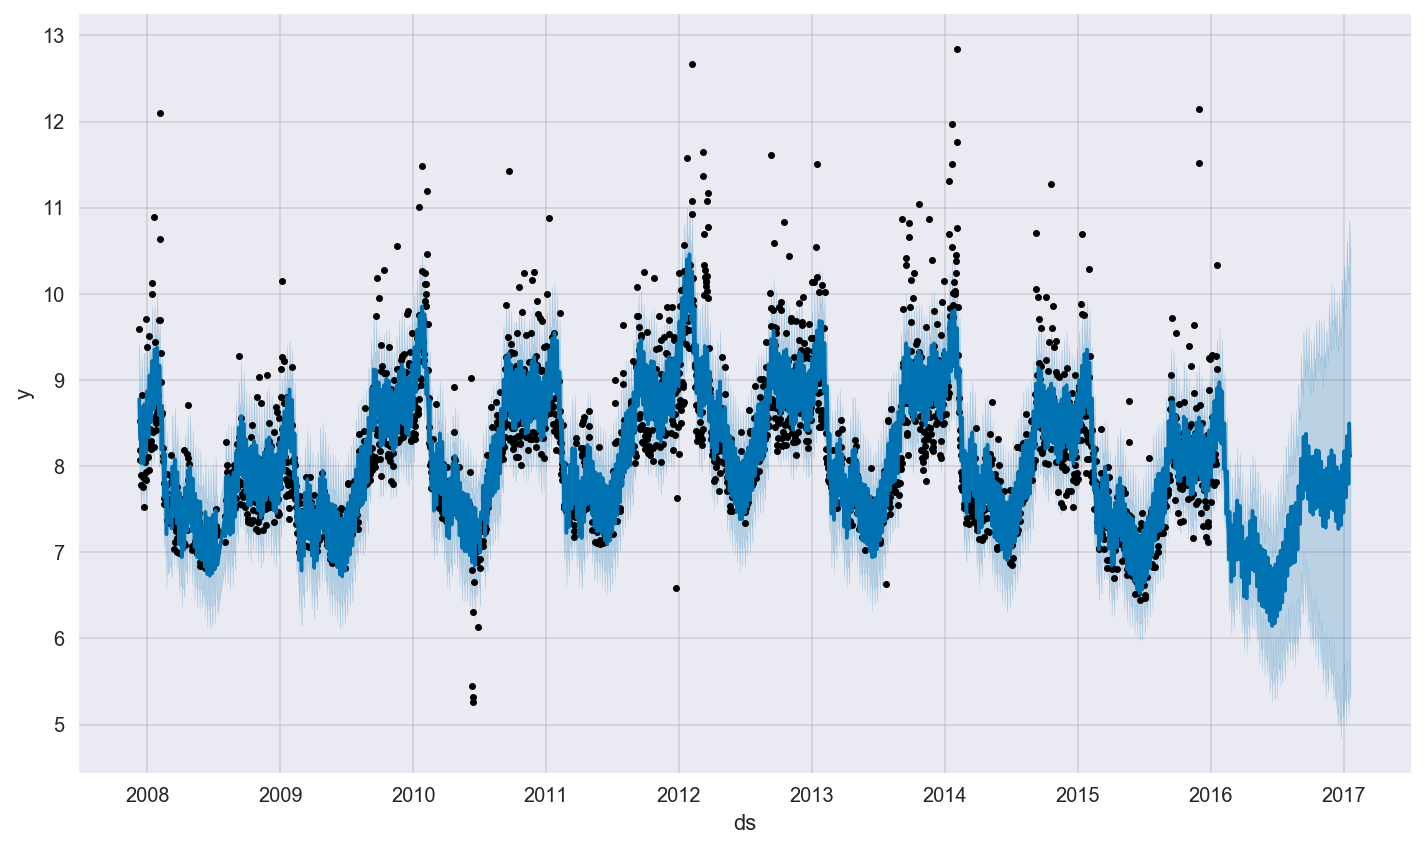

In [16]:
m1 = Prophet(changepoint_prior_scale=0.5)
forecast1 = m1.fit(df).predict(future)
m1.plot(forecast1);

Decreasing it will make the trend *less* flexible:

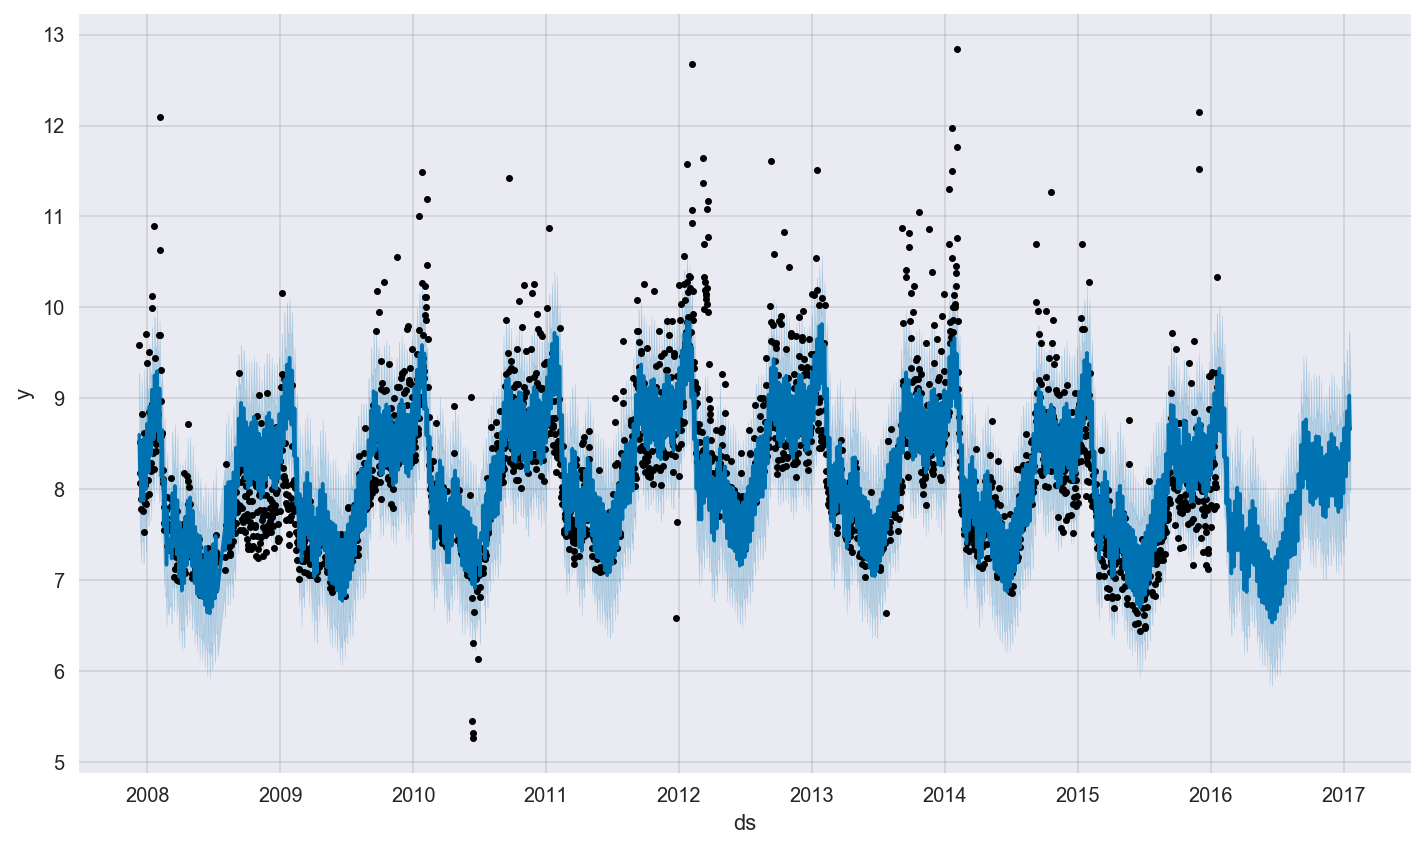

In [17]:
m2 = Prophet(changepoint_prior_scale=0.001)
forecast2 = m2.fit(df).predict(future)
m2.plot(forecast2);

If you wish, rather than using automatic changepoint detection you can **manually specify the locations** of potential changepoints with the **changepoints argument**.

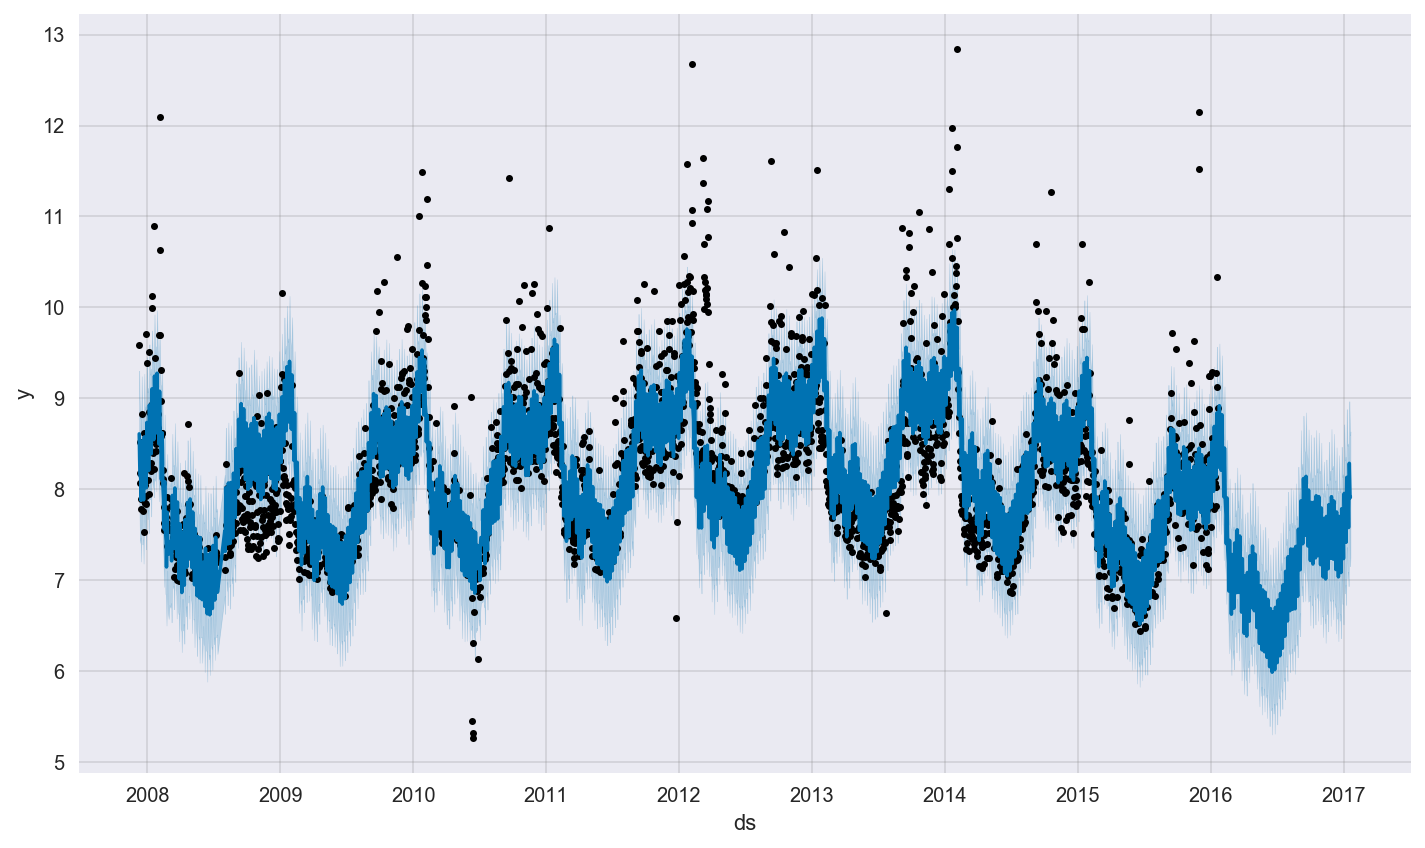

In [18]:
m3 = Prophet(changepoints=['2014-01-01'])
forecast3 = m3.fit(df).predict(future)
m3.plot(forecast3);

## Holiday Effects

If you have holidays that you’d like to model, **you must create a dataframe** for them. **It has two columns (holiday and ds) and a row for each occurrence of the holiday**. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). If they won’t repeat in the future, Prophet will model them and then not include them in the forecast.

You can also include columns **lower_window and upper_window** which extend the holiday out to [lower_window, upper_window] days around the date. For instance, if you wanted to included Christmas Eve in addition to Christmas you’d include lower_window=-1,upper_window=0. If you wanted to use Black Friday in addition to Thanksgiving, you’d include lower_window=0,upper_window=1.

In [19]:
#Here we create a dataframe that includes the dates of all of 
#Peyton Manning’s playoff appearances:

playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((playoffs, superbowls))

Above we have include the superbowl days as both playoff games and superbowl games. This means that the superbowl effect will be an additional additive bonus on top of the playoff effect.

Once the table is created, holiday effects are included in the forecast by passing them in with the holidays argument.

In [20]:
m4 = Prophet(holidays=holidays)
forecast4 = m4.fit(df).predict(future)

In [21]:
#The holiday effect can be seen in the forecast dataframe:
forecast4[(forecast4['playoff'] + forecast4['superbowl']).abs() > 0]\
[['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.224671,1.198000
2191,2014-02-03,1.901035,1.474798
2532,2015-01-11,1.224671,0.000000
2533,2015-01-12,1.901035,0.000000
2901,2016-01-17,1.224671,0.000000
2902,2016-01-18,1.901035,0.000000
2908,2016-01-24,1.224671,0.000000
2909,2016-01-25,1.901035,0.000000
2922,2016-02-07,1.224671,1.198000
2923,2016-02-08,1.901035,1.474798


The holiday effects will also show up in the components plot, where we see that there is a spike on the days around playoff appearances, with an especially large spike for the superbowl:

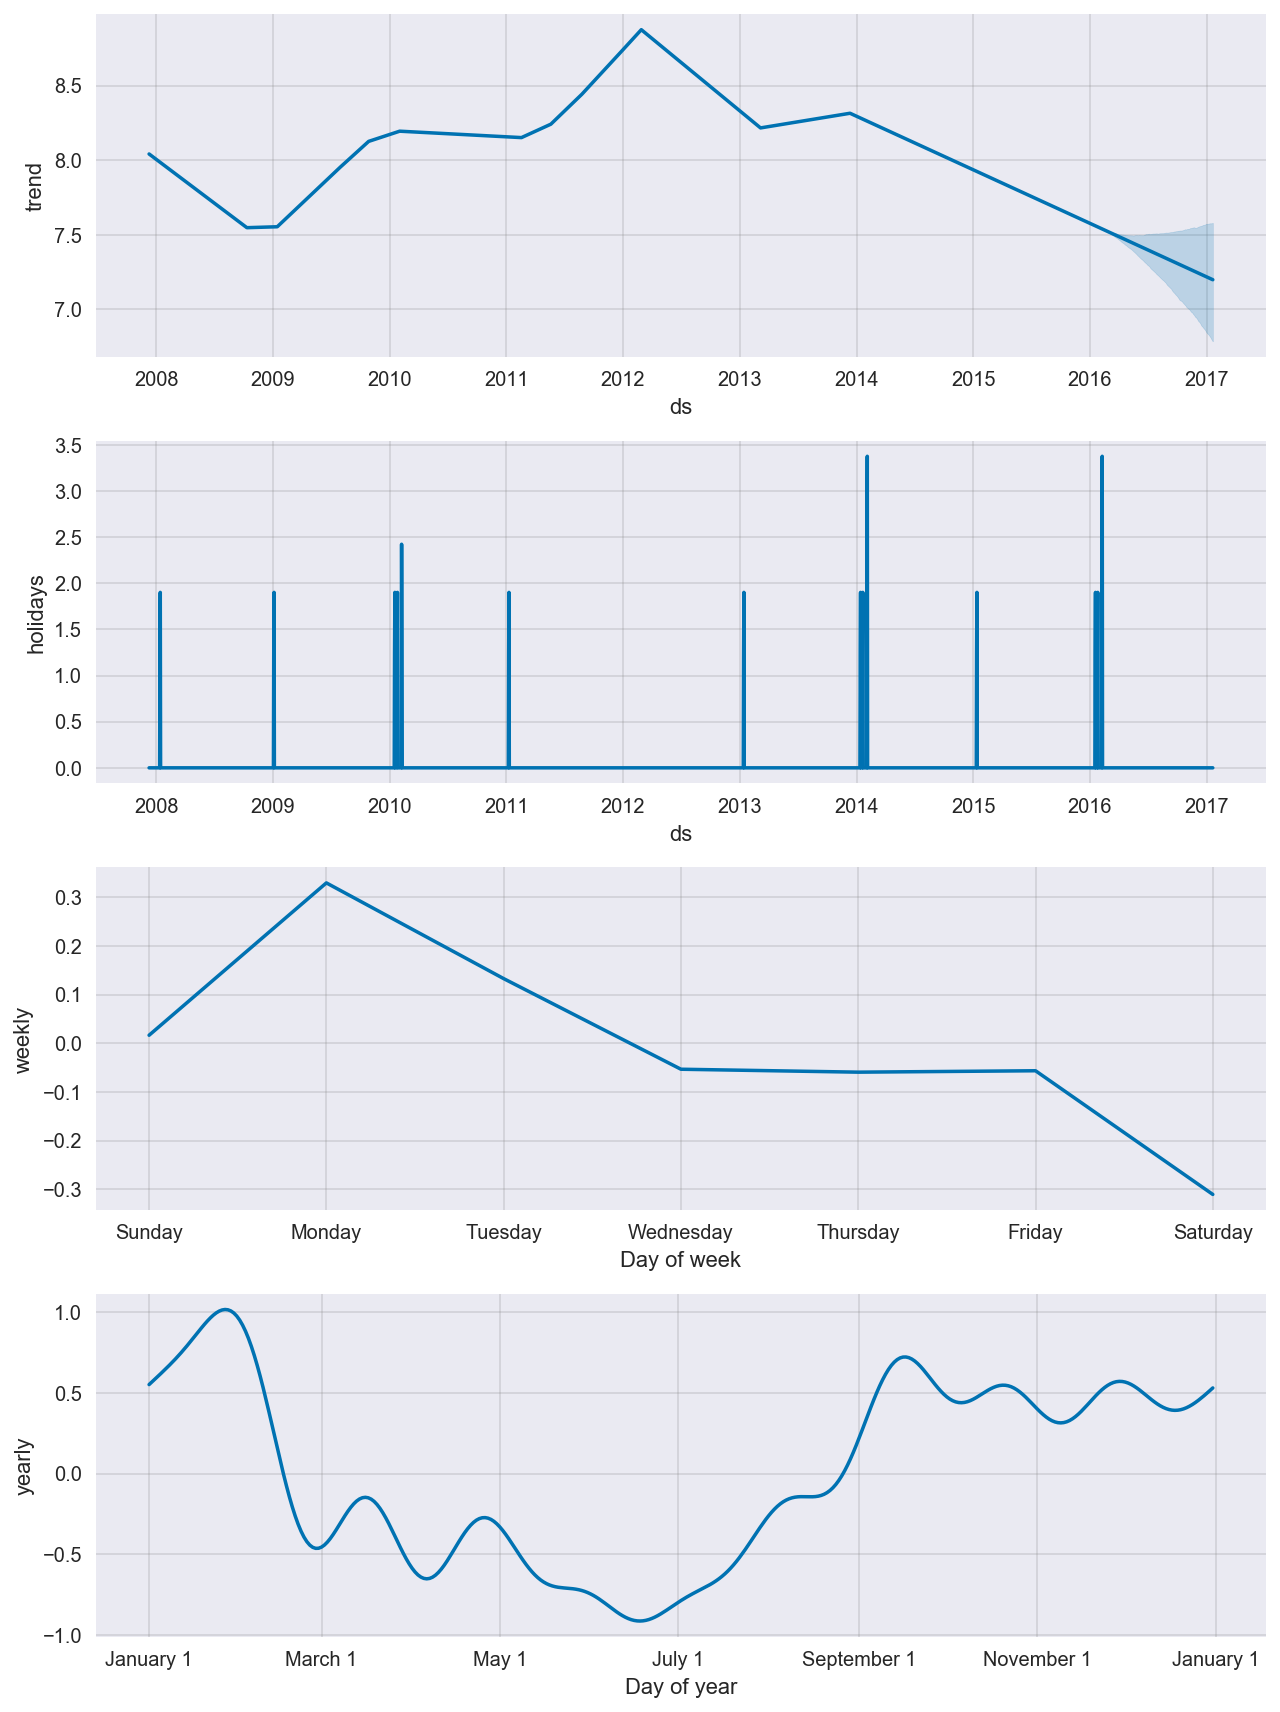

In [22]:
m4.plot_components(forecast4);

In [23]:
%%R
playoffs <- data_frame(
  holiday = 'playoff',
  ds = as.Date(c('2008-01-13', '2009-01-03', '2010-01-16',
                 '2010-01-24', '2010-02-07', '2011-01-08',
                 '2013-01-12', '2014-01-12', '2014-01-19',
                 '2014-02-02', '2015-01-11', '2016-01-17',
                 '2016-01-24', '2016-02-07')),
  lower_window = 0,
  upper_window = 1
)
superbowls <- data_frame(
  holiday = 'superbowl',
  ds = as.Date(c('2010-02-07', '2014-02-02', '2016-02-07')),
  lower_window = 0,
  upper_window = 1
)
holidays <- bind_rows(playoffs, superbowls)

In [24]:
%%R
df <- read.csv('Data/example_wp_peyton_manning.csv')
df$y <- log(df$y)
m <- prophet(df, holidays = holidays)

STAN OPTIMIZATION COMMAND (LBFGS)
init = user
save_iterations = 1
init_alpha = 0.001
tol_obj = 1e-12
tol_grad = 1e-08
tol_param = 1e-08
tol_rel_obj = 10000
tol_rel_grad = 1e+07
history_size = 5
seed = 1273597915
initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [25]:
%%R
future <- make_future_dataframe(m, periods=366)
frcst <- predict(m, future)

|======================================================|100% ~0 s remaining     

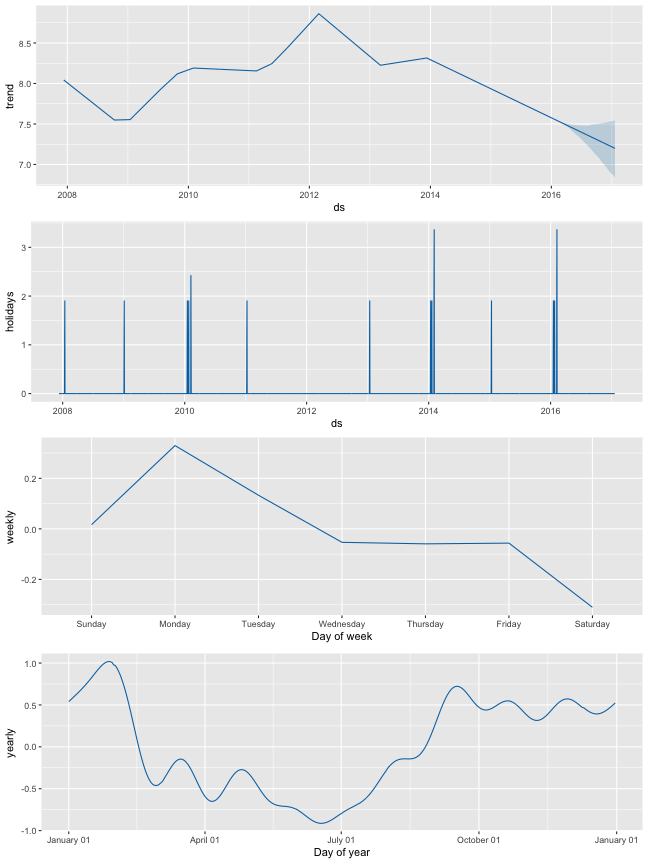

In [26]:
%%R -w 9 -h 12 -u in
prophet_plot_components(m, frcst);

In [27]:
#Manually re-create in Python the plots of the components with misplaced labels.

#comp = m4.predict_seasonal_components(df)
#comp.index = df.ds.values
f = forecast4.copy()
f = f.set_index('ds')
f.columns

Index([u't', u'trend', u'seasonal_lower', u'seasonal_upper', u'trend_lower',
       u'trend_upper', u'yhat_lower', u'yhat_upper', u'playoff',
       u'playoff_lower', u'playoff_upper', u'superbowl', u'superbowl_lower',
       u'superbowl_upper', u'weekly', u'weekly_lower', u'weekly_upper',
       u'yearly', u'yearly_lower', u'yearly_upper', u'seasonal', u'yhat'],
      dtype='object')

/Users/paulaalves/anaconda/envs/forecasts/lib/python2.7/site-packages/ipykernel/__main__.py:11: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/Users/paulaalves/anaconda/envs/forecasts/lib/python2.7/site-packages/ipykernel/__main__.py:23: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


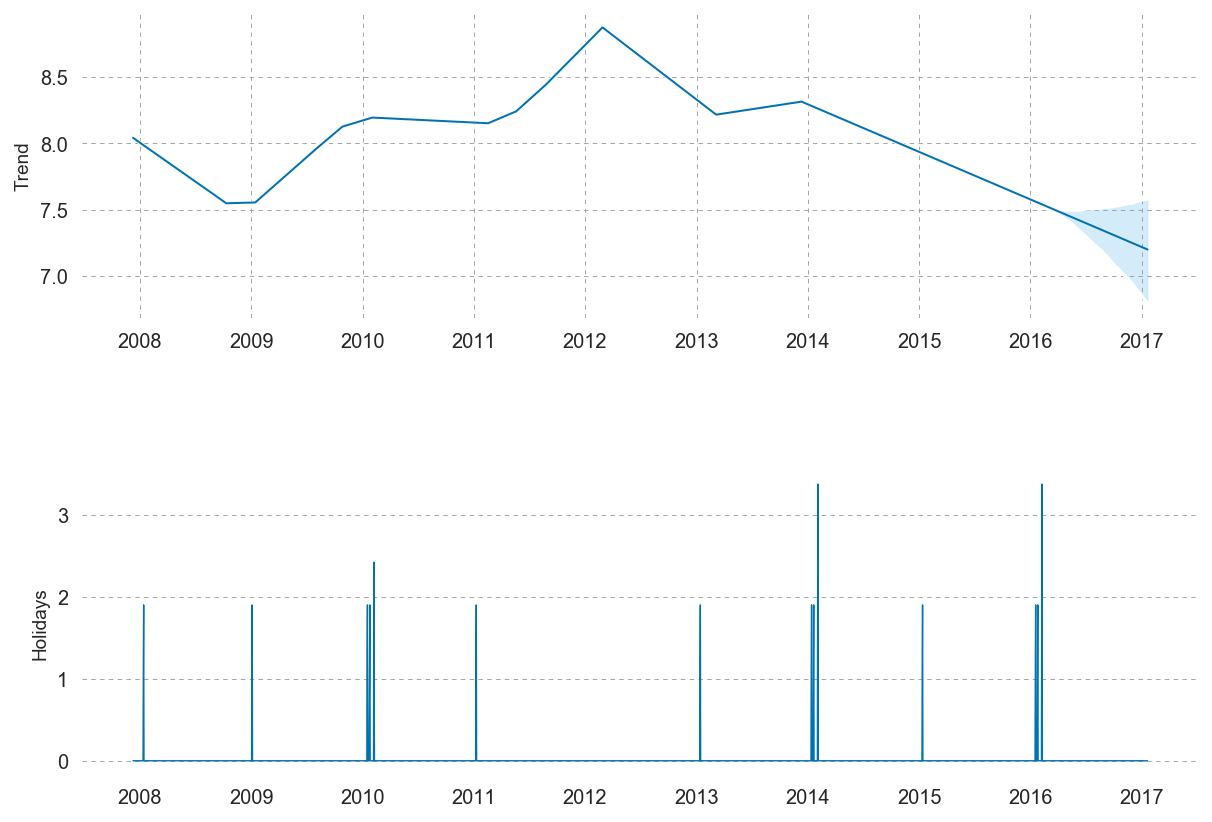

In [28]:
#Create figure with plots
fig = plt.figure(figsize = (10,7))
x = f.index

#Plot Trend
ax1=plt.subplot(2,1,1)
ax1.plot(x, f.trend_lower.values, color='#FFFFFF')
ax1.plot(x, f.trend_upper.values, color='#FFFFFF')
ax1.plot(x, f.trend.values, color='#0072B2', linewidth=1.) #0072B2 is "ggplot blue"
ax1.fill_between(x, f.trend_lower.values, f.trend_upper.values, color='#56B4E9', alpha=.25)
ax1.set_axis_bgcolor('#FFFFFF') #white
#library default for grid: c='gray', ls='-', lw=1., alpha=.2
ax1.grid(color='0.65', linestyle=':', linewidth=.5)
plt.ylabel('Trend', fontsize=9.5);
#plt.ylabel('Log Number of Page Views', fontsize=9.5);


#Plot Holidays
ax2=plt.subplot(2,1,2)
ax2.plot(x, (f.playoff.values+f.superbowl.values), color='#0072B2', linewidth=.7)
#ax2.plot(forecast4.ds.values, (forecast4.playoff.values+forecast4.superbowl.values), color='#0072B2', linewidth=.7)
ax2.yaxis.grid('True', color='0.65',linestyle=':', linewidth=.5)
ax2.set_axis_bgcolor('#FFFFFF')
plt.ylabel('Holidays', fontsize=9.5);


fig.subplots_adjust(hspace=.5)

If you find that the holidays are **overfitting**, you can adjust their prior scale to **smooth** them using the parameter **holidays_prior_scale**, which by default is 10:

In [29]:
m5 = Prophet(holidays=holidays, holidays_prior_scale=1).fit(df)
forecast5 = m5.predict(future)
forecast5[(forecast5['playoff'] + forecast5['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.317902,0.786721
2191,2014-02-03,1.989285,0.644941
2532,2015-01-11,1.317902,0.000000
2533,2015-01-12,1.989285,0.000000
2901,2016-01-17,1.317902,0.000000
2902,2016-01-18,1.989285,0.000000
2908,2016-01-24,1.317902,0.000000
2909,2016-01-25,1.989285,0.000000
2922,2016-02-07,1.317902,0.786721
2923,2016-02-08,1.989285,0.644941


The magnitude of the holiday effect has been reduced compared to before, especially for superbowls, which had the fewest observations. There is a parameter **seasonality_prior_scale** which similarly adjusts the extent to which the seasonality model will fit the data.

## Uncertainty Intervals

By default Prophet will return uncertainty intervals for the forecast yhat. There are several important assumptions behind these uncertainty intervals.
There are **three sources of uncertainty in the forecast**: uncertainty in the trend, uncertainty in the seasonality estimates, and additional observation noise.

**Uncertainty in the trend:** The biggest source of uncertainty in the forecast is the potential for future trend changes. We assume that the average frequency and magnitude of trend changes in the future will be the same as that which we observe in the history. We project these trend changes forward and by computing their distribution we obtain uncertainty intervals. This assumption is probably not true, so you should **not** expect to get accurate coverage on these uncertainty intervals.

In allowing higher flexibility in the trend rate by increasing the changepoint_prior_scale parameter, we increase the forecast uncertainty. This is because if we model more rate changes in the history then we will expect more in the future. This makes the uncertainty intervals a useful indicator of overfitting. The width of the uncertainty intervals (by default 80%) can be set using the parameter **interval_width**:

In [30]:
m6 = Prophet(interval_width=0.95)
forecast6 = m6.fit(df).predict(future)

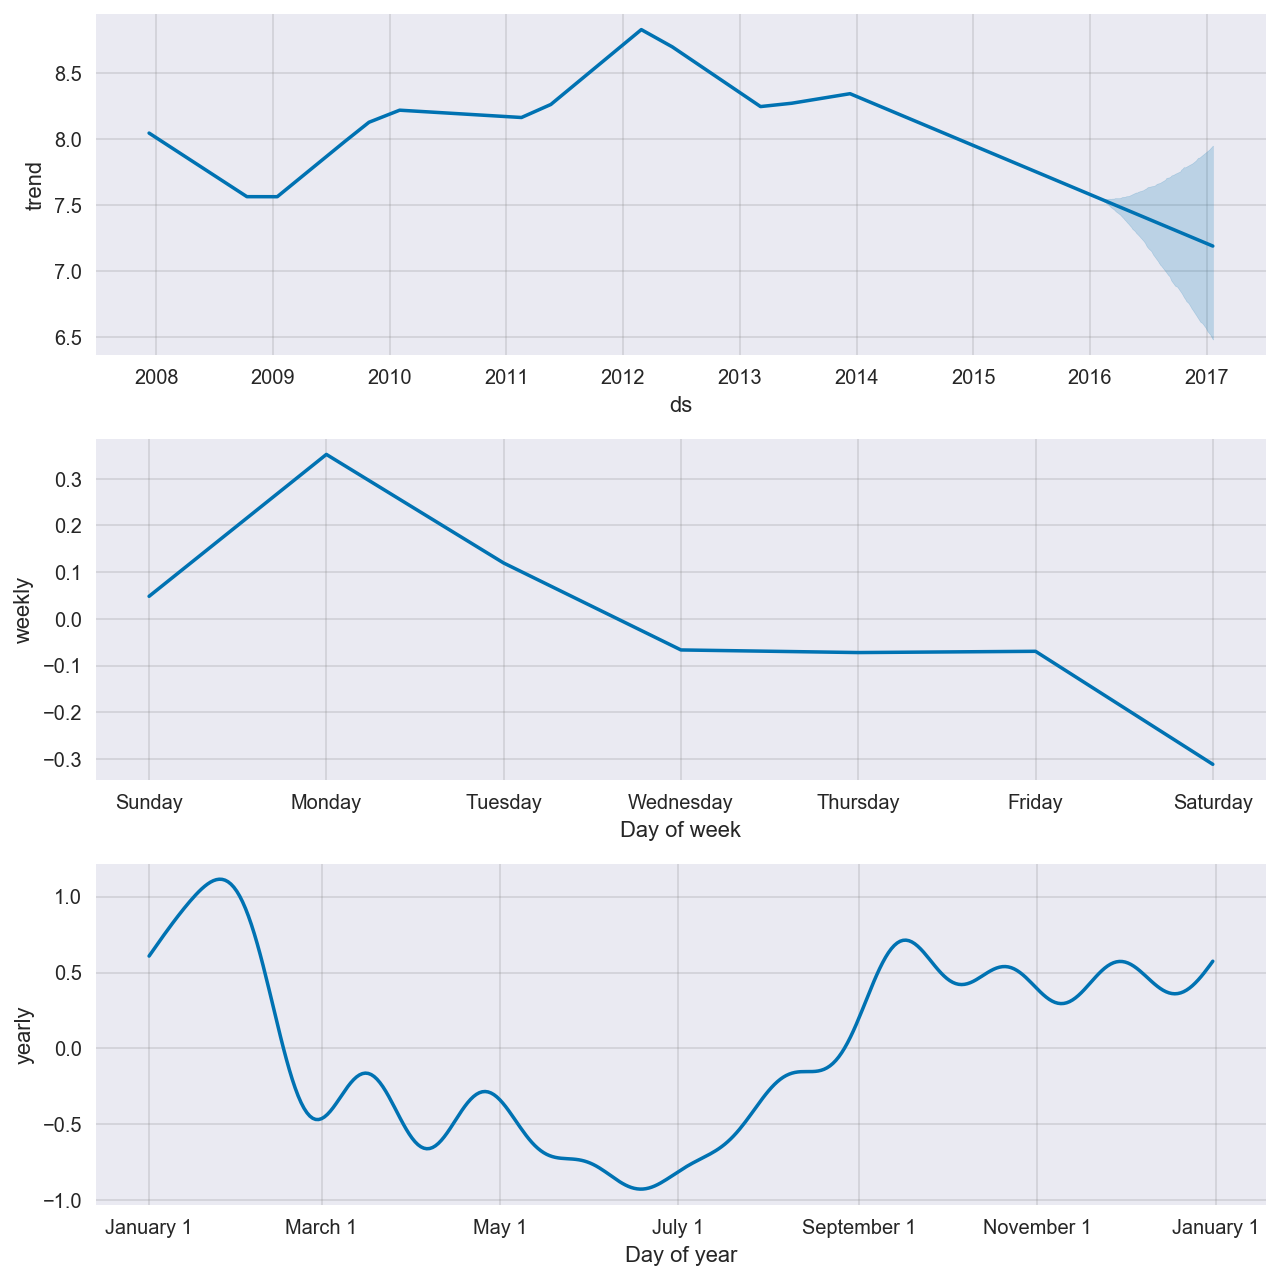

In [31]:
m6.plot_components(forecast6);

**Uncertainty in seasonality:** by default Prophet will only return uncertainty in the trend and observation noise. To get uncertainty in seasonality, you **must do full Bayesian sampling**. This is done using the parameter **mcmc.samples** (which defaults to 0). This replaces the typical MAP estimation with MCMC sampling, and **takes much longer** - think 10 minutes instead of 10 seconds. If you do full sampling, then you will see the uncertainty in seasonal components when you plot them:

In [32]:
#This takes veeeeery long to run
#m7 = Prophet(mcmc_samples=500)

In [33]:
#forecast7 = m7.fit(df).predict(future)

In [34]:
#m7.plot_components(forecast7);